In [1]:
from typing import Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AnyMessage,AIMessage
from langgraph.graph import StateGraph, START,END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt,Command
from dotenv import load_dotenv
from typing import TypedDict
from langchain_core.messages import BaseMessage
import os

d:\GITHUB\Projects\ChatBot_In_LangGraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
llm = ChatGoogleGenerativeAI(
    model="models/gemini-2.0-flash",
    api_key=os.getenv("GOOGLE_API_KEY"),
    max_retries=0
)


In [4]:
print("Using model:", llm.model)

Using model: models/gemini-2.0-flash


In [5]:
from langgraph.graph.message import add_messages
class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage],add_messages]

In [6]:
# def chat_node(state:ChatState):

#     decision = interrupt({
#         "type":"approval",
#         "reasone":"Model is about to answer a user question.",
#         "question":state["messages"][-1].content,
#         "instruction":"Approve this question? yes/no"
#     })

#     if decision["approved"]=="no":
#         return AIMessage(content="Your question was not approved by the moderator.")
#     else:
#         response = llm.invoke(state["messages"])
#         return {"messages":[response]}

def chat_node(state: ChatState):

    decision = interrupt({
        "type": "approval",
        "reasone": "Model is about to answer a user question.",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })

    if decision["approved"] == "no":
        return {
            "messages": [
                AIMessage(content="Your question was not approved by the moderator.")
            ]
        }
    else:
        response = llm.invoke(state["messages"])
        return {
            "messages": [response]
        }



In [7]:
builder = StateGraph(ChatState)
builder.add_node("chat",chat_node)

builder.add_edge(START,"chat")
builder.add_edge("chat",END)

checkpointer = MemorySaver()
app = builder.compile(checkpointer=checkpointer)

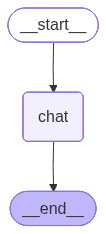

In [8]:
app

In [9]:
# Create a new thread id for this conversation
config = {"configurable":{"thread_id":"1234"}}
# ---- STEP 1: user asks a question ----
initial_input = {
    "messages":[
        ("user", "Explain gradient descent in very simple terms.")
    ]
}
result = app.invoke(initial_input,config=config)


In [10]:
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='f90be58c-1273-4854-8351-cc5111ca6075')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reasone': 'Model is about to answer a user question.', 'question': 'Explain gradient descent in very simple terms.', 'instruction': 'Approve this question? yes/no'}, id='a099762e1d5fc1f9e844617fe7364db1')]}

In [11]:
message = result['__interrupt__'][0].value
message

{'type': 'approval',
 'reasone': 'Model is about to answer a user question.',
 'question': 'Explain gradient descent in very simple terms.',
 'instruction': 'Approve this question? yes/no'}

In [12]:
user_input = input(f"\nBackend message - {message} \n Approve this question? yes/no: ")

In [13]:
final_result = app.invoke(
    Command(resume={"approved": user_input}),
    config=config
)


In [14]:
print(final_result["messages"][-1].content)

Your question was not approved by the moderator.
